In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sb

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
x = pd.read_csv('/content/drive/MyDrive/TataSteel10years.csv')
# x = pd.read_csv('TISC Historical Data.csv')

In [33]:
x.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,06/19/2024,180.00,182.26,182.48,179.35,27.46M,-0.62%
1,06/18/2024,181.12,183.80,184.60,180.60,35.03M,-1.11%
2,06/14/2024,183.15,182.95,183.50,181.40,28.51M,0.32%
3,06/13/2024,182.56,183.40,184.10,180.51,36.67M,0.18%
4,06/12/2024,182.23,182.25,183.87,181.50,33.31M,0.50%


In [68]:
import altair as alt
alt.Chart(x).mark_point().encode(
    x='High:Q',
    y='Low:Q'
)


alt.Chart(...)

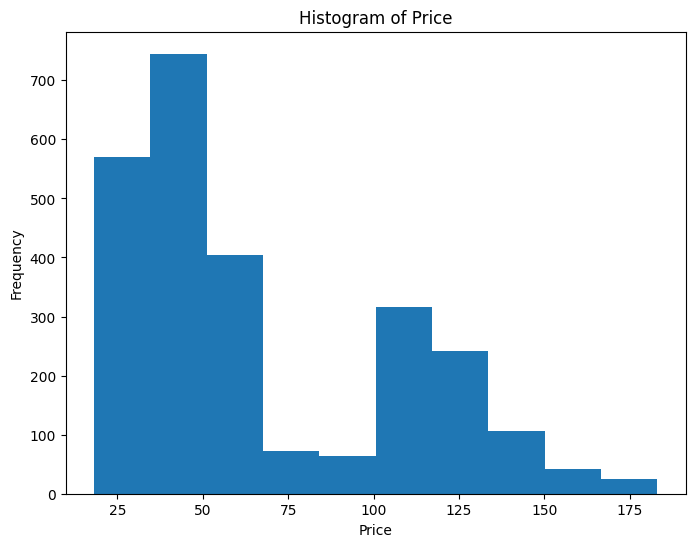

In [35]:
plt.figure(figsize=(8, 6))
plt.hist(x['Price'], bins=10)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram of Price')
plt.show()

In [36]:
reversed_x = x.iloc[::-1]

In [37]:
x_sorted = reversed_x.reset_index(drop=True)

In [38]:
x_sorted['Date'] = pd.to_datetime(x_sorted['Date'])

split = int(len(x_sorted)*0.7)
test = x_sorted[split:]
train = x_sorted[:split]
# test = x_sorted[x_sorted['Date'].dt.strftime('%Y').str.startswith('2024')]
# train = x_sorted[x_sorted['Date'] <= '2023-12-31']
test = test.reset_index(drop=True)
train = train.reset_index(drop=True)

In [39]:
train.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2014-01-01,38.21,38.13,38.29,38.01,12.53M,0.39%
1,2014-01-02,37.61,38.22,39.07,37.41,41.99M,-1.57%
2,2014-01-03,37.01,37.37,37.63,36.70,33.42M,-1.60%
3,2014-01-06,36.63,36.87,37.30,36.30,28.39M,-1.03%
4,2014-01-07,35.41,36.78,36.96,35.22,40.94M,-3.33%


In [40]:
test.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2021-05-04,106.39,107.44,108.67,105.75,249.62M,-0.08%
1,2021-05-05,107.01,108.40,108.83,104.70,192.50M,0.59%
2,2021-05-06,110.09,105.50,112.90,104.25,464.35M,2.87%
3,2021-05-07,118.24,113.50,119.20,113.01,540.75M,7.40%
4,2021-05-10,121.64,121.00,122.90,120.00,280.81M,2.88%


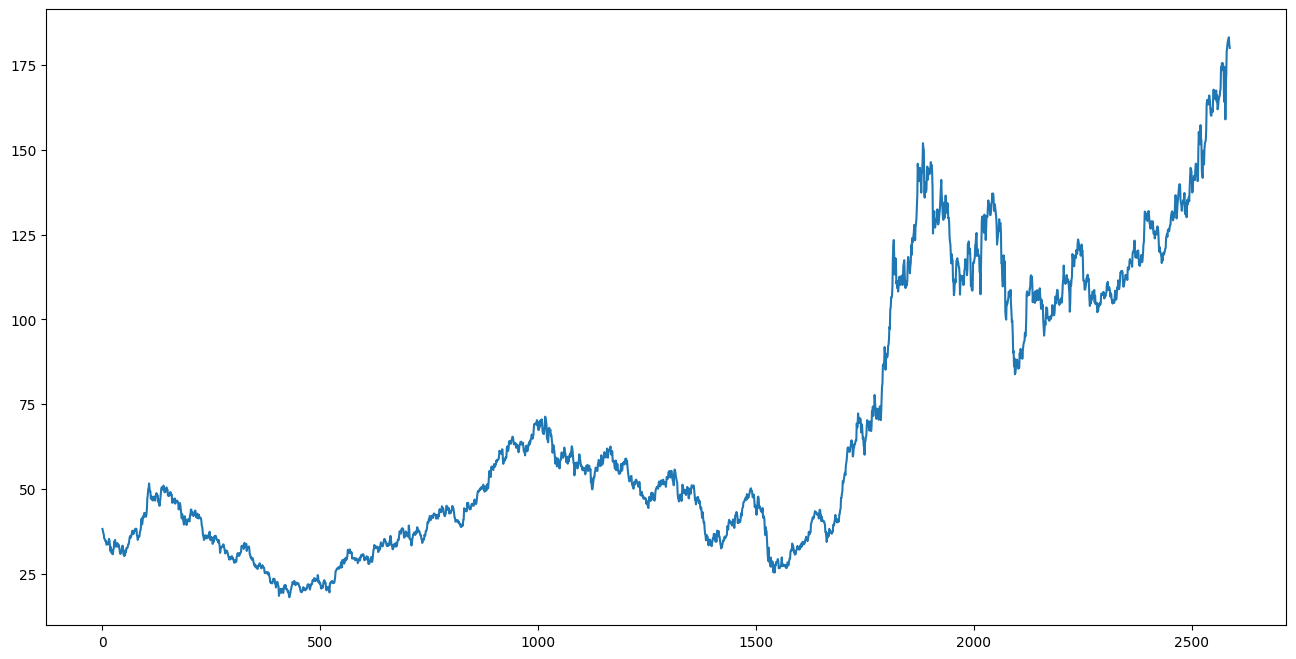

In [41]:
plt.figure(figsize=(16,8))
plt.plot(x_sorted["Price"], label="Day-wise price")

In [42]:
x.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

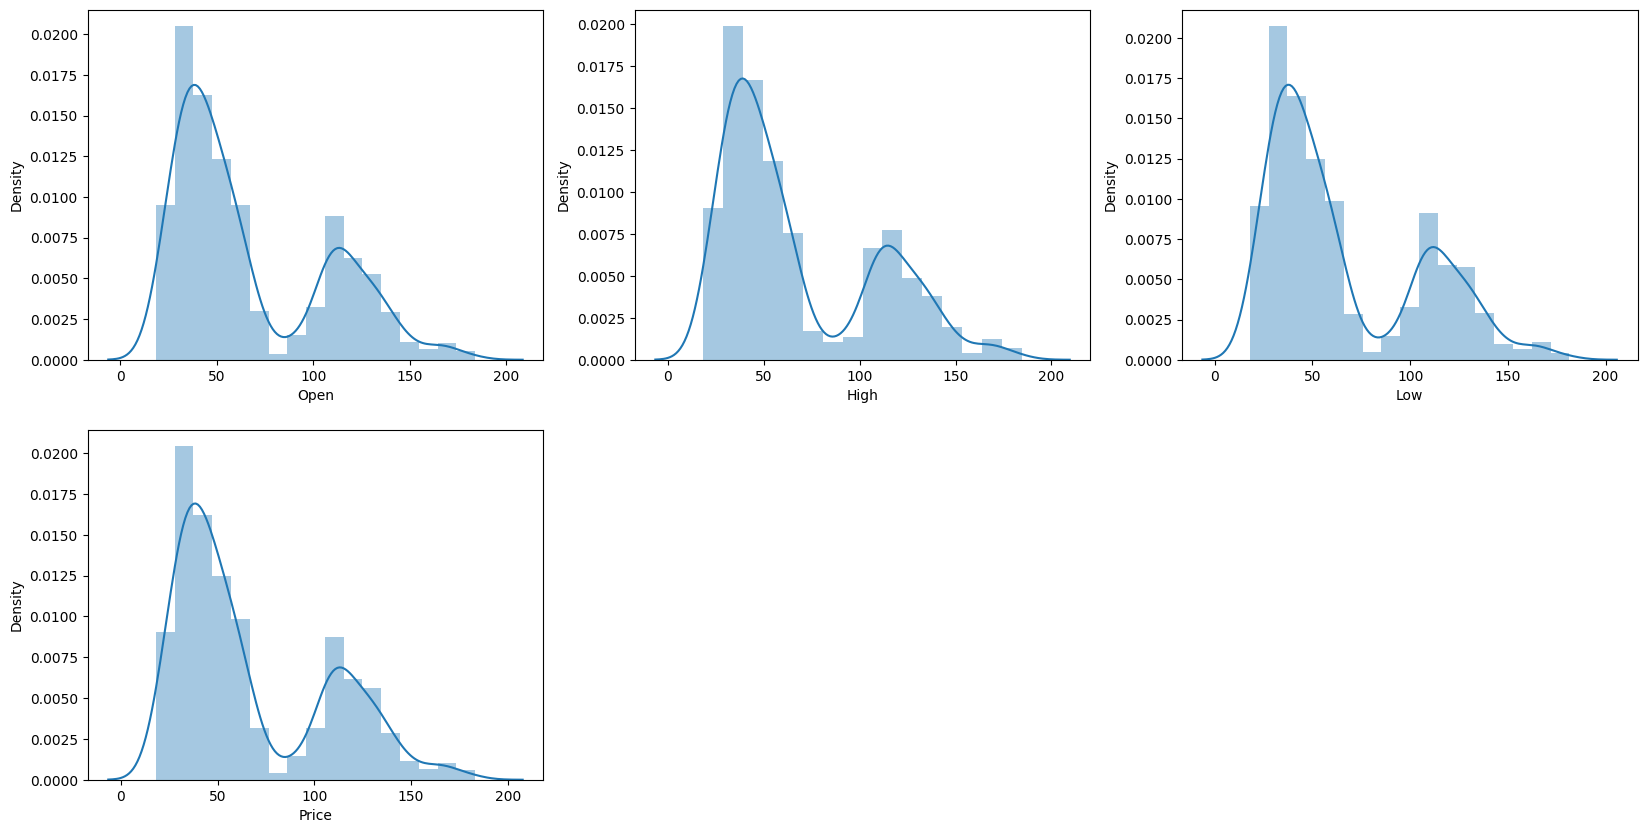

In [43]:
features = ['Open', 'High', 'Low', 'Price']

plt.subplots(figsize=(20,10))

for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sb.distplot(x_sorted[col])
plt.show()


In [44]:
features = ['Open', 'High', 'Low', 'Price']
training_set = train[features].values

In [45]:
training_set.shape

(1811, 4)

In [46]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [47]:
training_set_scaled

array([[0.23278302, 0.22342954, 0.23936614, 0.22782805],
       [0.23384434, 0.23225806, 0.23221732, 0.22104072],
       [0.22382075, 0.21595925, 0.22375789, 0.21425339],
       ...,
       [0.94233491, 0.96366723, 0.95770285, 0.96233032],
       [0.99068396, 0.98143746, 0.99118313, 0.96527149],
       [1.        , 1.        , 1.        , 1.        ]])

In [48]:
X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i, :])
    y_train.append(training_set_scaled[i, -1])
X_train, y_train = np.array(X_train), np.array(y_train)

In [49]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 4))

In [50]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [51]:
regressor = Sequential()

regressor.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 4)))
regressor.add( Dropout(0.5))

regressor.add(LSTM(units = 128, return_sequences = True))
regressor.add( Dropout(0.5))

regressor.add(LSTM(units = 128, return_sequences = True))
regressor.add( Dropout(0.5))

regressor.add(LSTM(units = 128))
regressor.add( Dropout(0.5))

regressor.add(Dense(units = 1))

In [52]:
X_train.shape

(1751, 60, 4)

In [53]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mean_absolute_error'])
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 128)           68096     
                                                                 
 dropout_4 (Dropout)         (None, 60, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 60, 128)           131584    
                                                                 
 dropout_5 (Dropout)         (None, 60, 128)           0         
                                                                 
 lstm_6 (LSTM)               (None, 60, 128)           131584    
                                                                 
 dropout_6 (Dropout)         (None, 60, 128)           0         
                                                                 
 lstm_7 (LSTM)               (None, 128)              

In [54]:
regressor.fit(X_train, y_train, epochs = 10, batch_size = 32, verbose=1)

Epoch 1/10
55/55 [==============================] - 33s 428ms/step - loss: 0.0078 - mean_absolute_error: 0.0598
Epoch 2/10
55/55 [==============================] - 20s 360ms/step - loss: 0.0034 - mean_absolute_error: 0.0429
Epoch 3/10
55/55 [==============================] - 29s 537ms/step - loss: 0.0043 - mean_absolute_error: 0.0489
Epoch 4/10
55/55 [==============================] - 23s 395ms/step - loss: 0.0030 - mean_absolute_error: 0.0401
Epoch 5/10
55/55 [==============================] - 21s 385ms/step - loss: 0.0027 - mean_absolute_error: 0.0374
Epoch 6/10
55/55 [==============================] - 22s 400ms/step - loss: 0.0027 - mean_absolute_error: 0.0378
Epoch 7/10
55/55 [==============================] - 22s 405ms/step - loss: 0.0024 - mean_absolute_error: 0.0363
Epoch 8/10
55/55 [==============================] - 30s 558ms/step - loss: 0.0022 - mean_absolute_error: 0.0351
Epoch 9/10
55/55 [==============================] - 20s 357ms/step - loss: 0.0022 - mean_absolute_error:

In [55]:
actual_stock_price = test.iloc[:,1:2].values

In [56]:
dataset_total = pd.concat((train, test), axis = 0) #train['Price']
inputs = dataset_total[features][len(dataset_total) - len(test) - 60:].values

sc = MinMaxScaler(feature_range=(0,1))
inputs = sc.fit_transform(inputs)

X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, :])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 4))

In [57]:
predicted_price = regressor.predict(X_test)
dummy_data = np.zeros((predicted_price.shape[0], 3))
temp_array = np.concatenate((dummy_data, predicted_price), axis=1)
predicted_price_original_scale = sc.inverse_transform(temp_array)
predicted_price = predicted_price_original_scale[:, -1]

25/25 [==============================] - 4s 110ms/step


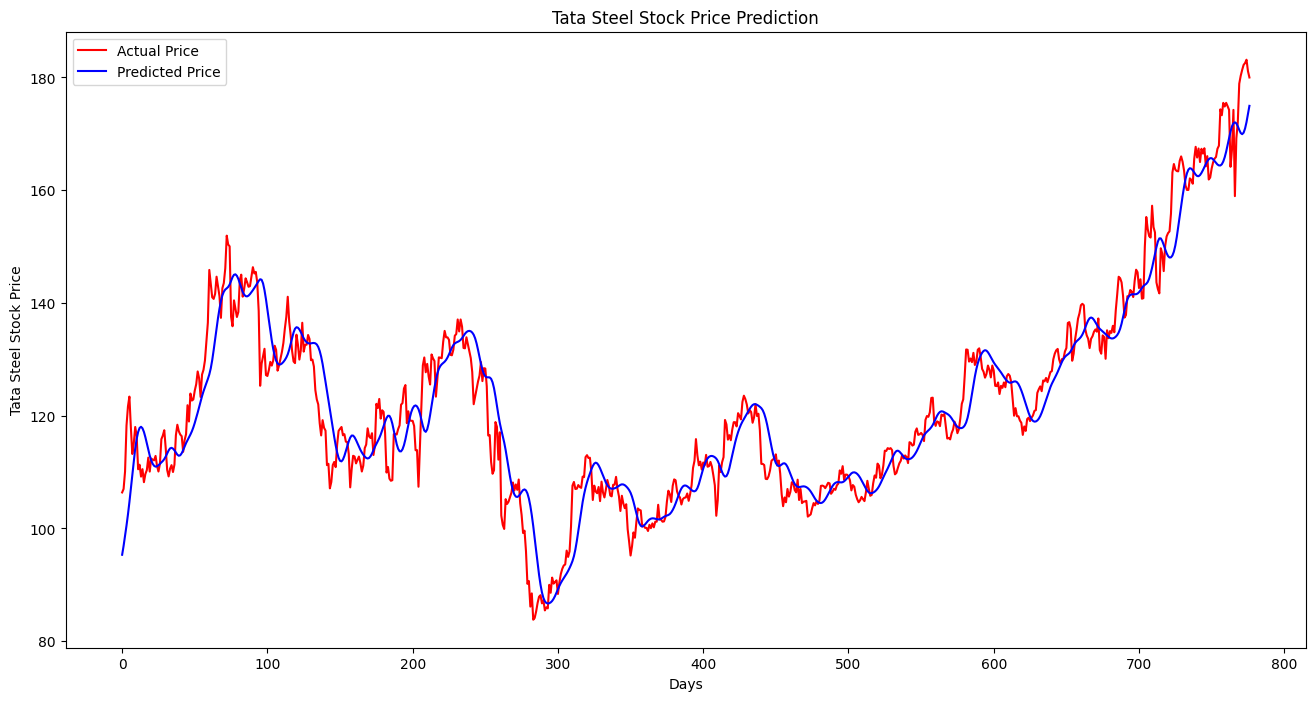

In [58]:
plt.subplots(figsize=(16,8))
plt.plot(actual_stock_price, color = 'red', label = 'Actual Price')
plt.plot(predicted_price, color = 'blue', label = 'Predicted Price')
plt.title('Tata Steel Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Tata Steel Stock Price')
plt.legend()

plt.show()

In [59]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

actual_direction = np.sign(np.diff(actual_stock_price.flatten()))
predicted_direction = np.sign(np.diff(predicted_price))
# mda = np.mean(actual_direction == predicted_direction) * 100

directional_accuracy = np.sign(actual_stock_price[1:] - actual_stock_price[:-1]) == np.sign(predicted_price[1:] - actual_stock_price[:-1])
mda = np.mean(directional_accuracy)
print("Directional Accuracy:", mda*100)

mape = np.mean(np.abs((actual_stock_price - predicted_price) / actual_stock_price)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')


Directional Accuracy: 51.3260242852588
Mean Absolute Percentage Error (MAPE): 16.07%


In [60]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(actual_stock_price, predicted_price))

# Calculate R-squared (R2)
r2 = r2_score(actual_stock_price, predicted_price)

print('RMSE:', rmse)
print('R2:', r2)

RMSE: 5.6073075642782255
R2: 0.9103734516733035
